In [6]:
import math
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import stats, integrate
import pandas as pd
import pytz
import datetime as dt

In [7]:
import biosppy
from biosppy import storage
from biosppy.signals import ecg

## Example of ECG signal visualization with biospy 

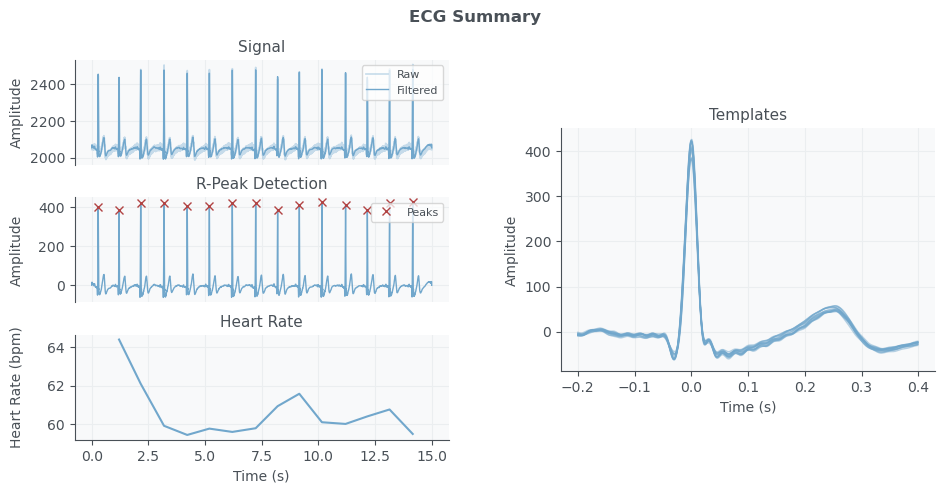

In [8]:
ecg_example = "C:/Users/muhammad.saif/Desktop/repos_ixp/BioSPPy/examples/ecg.txt"

#ecg_example = "/home/muhammad/Desktop/repos_ixp/BioSPPy/examples/ecg.txt"
# load raw ECG signal
signal, mdata = storage.load_txt(ecg_example)
out = ecg.ecg(signal=signal, sampling_rate=1000., show=True,interactive=False)

## Read and manipulate psychopy and shimmer files 

In [9]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    

## Time Domain HRV

In [10]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output



def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

## Paths  and inputs

In [11]:
event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]


In [12]:

#psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
#ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv"

psychopy_file_path = "D:/Datasets/data_sony_digiRelax/study/VP005_081123/Psychopy_data/VP005_081123_DigiRelax_Experiment_2023-11-08_14h17.35.226.csv"
ecg_file_path ="D:/Datasets/data_sony_digiRelax/study/VP005_081123/Shimmer_data/2023-11-08_13.52.04_VP005_081123_SD_Session1/VP005_081123_Session1_Shimmer_6B1E_Calibrated_SD.csv" 

ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"

#col_interest_psychopy = "tsst_prep_ts"

In [13]:
event_interest = event_interest_list_new[1]
#ä offset time in mins
time_offset = 5


In [14]:
psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest)
start_timestamp = non_nan_timestamp[0]



stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)


In [48]:
psychopy_df

,Reference_time,baseline_instruction_ts,end_countDown_3min_ts,sam_e_ts,sam_a_ts,saliva_probe_1_ts,change_room_ts,tsst_prep_ts,end_countDown_5min_prep_ts,tsst_pres_ts,end_countDown_5min_pres_ts,end_countDown_5min_arithmetic_ts,tsst_end_exp_ts,saliva_probe_2_ts,relaxation_prep_ts,relaxation_ts,saliva_probe_3_ts,limeSurvey_ts,saliva_probe_4_ts,end_exp_ts
0,1.699449e+09,1.699449e+09,1.699450e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,1.699450e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,1.699450e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.699450e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,1.699450e+09,1.699450e+09,1.699450e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.699450e+09,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.699451e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print(start_timestamp)
print(stop_timestamp)

1699449492.5466542
1699449792.546654


In [16]:
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print(start_time)
print(end_time)

2023-11-08 14:18:12.546654+01:00
2023-11-08 14:23:12.546654+01:00


In [17]:
ecg_df = read_shimmer_sensor(ecg_file_path)

In [18]:
selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)


In [33]:
sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

In [34]:
sliced_ecg_df

,Shimmer_6B1E_Timestamp_Unix_CAL,Shimmer_6B1E_ECG_LA-RA_24BIT_CAL
0,1.699449e+09,78.57175452372486
1,1.699449e+09,78.57478363213345
2,1.699449e+09,78.57319695630038
3,1.699449e+09,78.58127457872327
4,1.699449e+09,78.57355756444426
...,...,...
76690,1.699450e+09,75.36630873278484
76691,1.699450e+09,75.37914638270694
76692,1.699450e+09,75.35794262384685
76693,1.699450e+09,75.32505516112509


In [35]:
start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print(start_time_hr)
print(end_time_hr)

2023-11-08 14:18:12.549255+01:00
2023-11-08 14:23:12.545349+01:00


In [36]:
sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

In [37]:
ecg_array = sliced_ecg_df["heartrate"].values

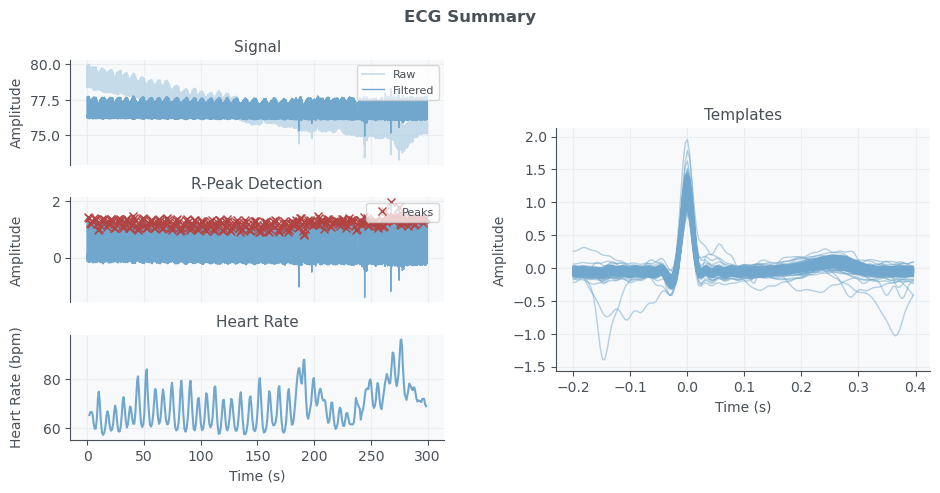

In [38]:
sampling_frequency_hw=256
out = ecg.ecg(signal=ecg_array, sampling_rate=sampling_frequency_hw, show=True,interactive=False)

In [39]:
sliced_ecg_df["filtered"] = out["filtered"]

In [40]:
sliced_ecg_df

,Shimmer_6B1E_Timestamp_Unix_CAL,Shimmer_6B1E_ECG_LA-RA_24BIT_CAL,heartrate,filtered
0,1.699449e+09,78.57175452372486,78.571755,0.052598
1,1.699449e+09,78.57478363213345,78.574784,0.071886
2,1.699449e+09,78.57319695630038,78.573197,0.070447
3,1.699449e+09,78.58127457872327,78.581275,0.050058
4,1.699449e+09,78.57355756444426,78.573558,0.033834
...,...,...,...,...
76690,1.699450e+09,75.36630873278484,75.366309,-0.021996
76691,1.699450e+09,75.37914638270694,75.379146,0.000287
76692,1.699450e+09,75.35794262384685,75.357943,0.019213
76693,1.699450e+09,75.32505516112509,75.325055,0.010936


array([  236,   468,   710,   930,  1161,  1410,  1672,  1933,  2181,
        2394,  2584,  2799,  3051,  3322,  3593,  3857,  4113,  4351,
        4568,  4804,  5063,  5326,  5586,  5840,  6074,  6283,  6508,
        6762,  7029,  7293,  7549,  7792,  8001,  8204,  8428,  8678,
        8937,  9194,  9427,  9642,  9865, 10105, 10361, 10612, 10852,
       11061, 11251, 11436, 11630, 11864, 12119, 12374, 12627, 12871,
       13081, 13245, 13434, 13634, 13871, 14125, 14384, 14632, 14872,
       15090, 15285, 15481, 15702, 15948, 16200, 16449, 16683, 16890,
       17085, 17292, 17523, 17769, 18022, 18273, 18515, 18736, 18936,
       19124, 19324, 19565, 19826, 20088, 20346, 20600, 20832, 21030,
       21216, 21414, 21656, 21922, 22188, 22444, 22689, 22909, 23102,
       23291, 23491, 23735, 24000, 24264, 24516, 24749, 24956, 25159,
       25389, 25649, 25913, 26169, 26418, 26645, 26843, 27042, 27279,
       27535, 27790, 28043, 28288, 28506, 28699, 28891, 29107, 29369,
       29641, 29907,

In [44]:
r_peaks_selected = [r_p for r_p in r_peaks if r_p >= 236 and r_p <= 1410]

In [ ]:
len(r_peaks_selected)

6

In [46]:
starting_index_slcide_df= sliced_ecg_df.index[0]
sampfrom = starting_index_slcide_df
sampto = starting_index_slcide_df+256*time_offset*60
nr_plots = 5

0
15360
15360
30720
30720
46080
46080
61440
61440
76800


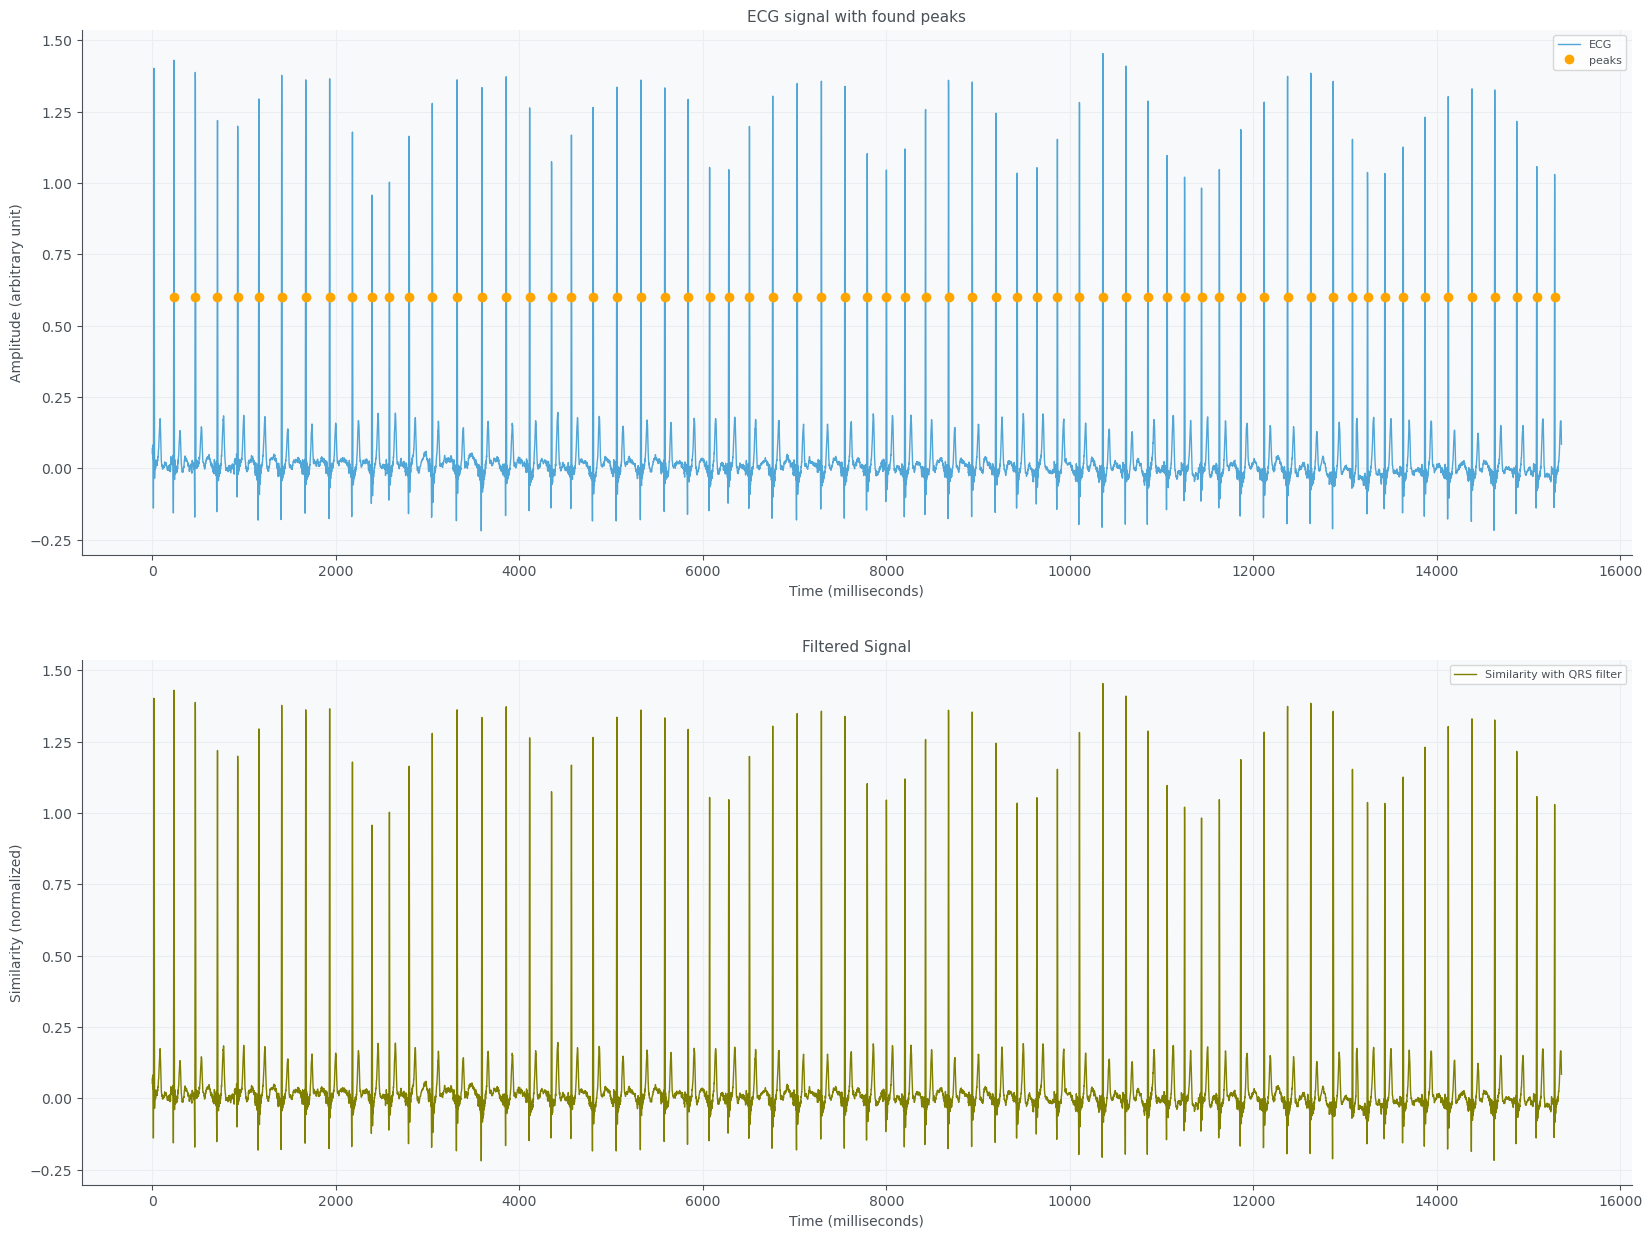

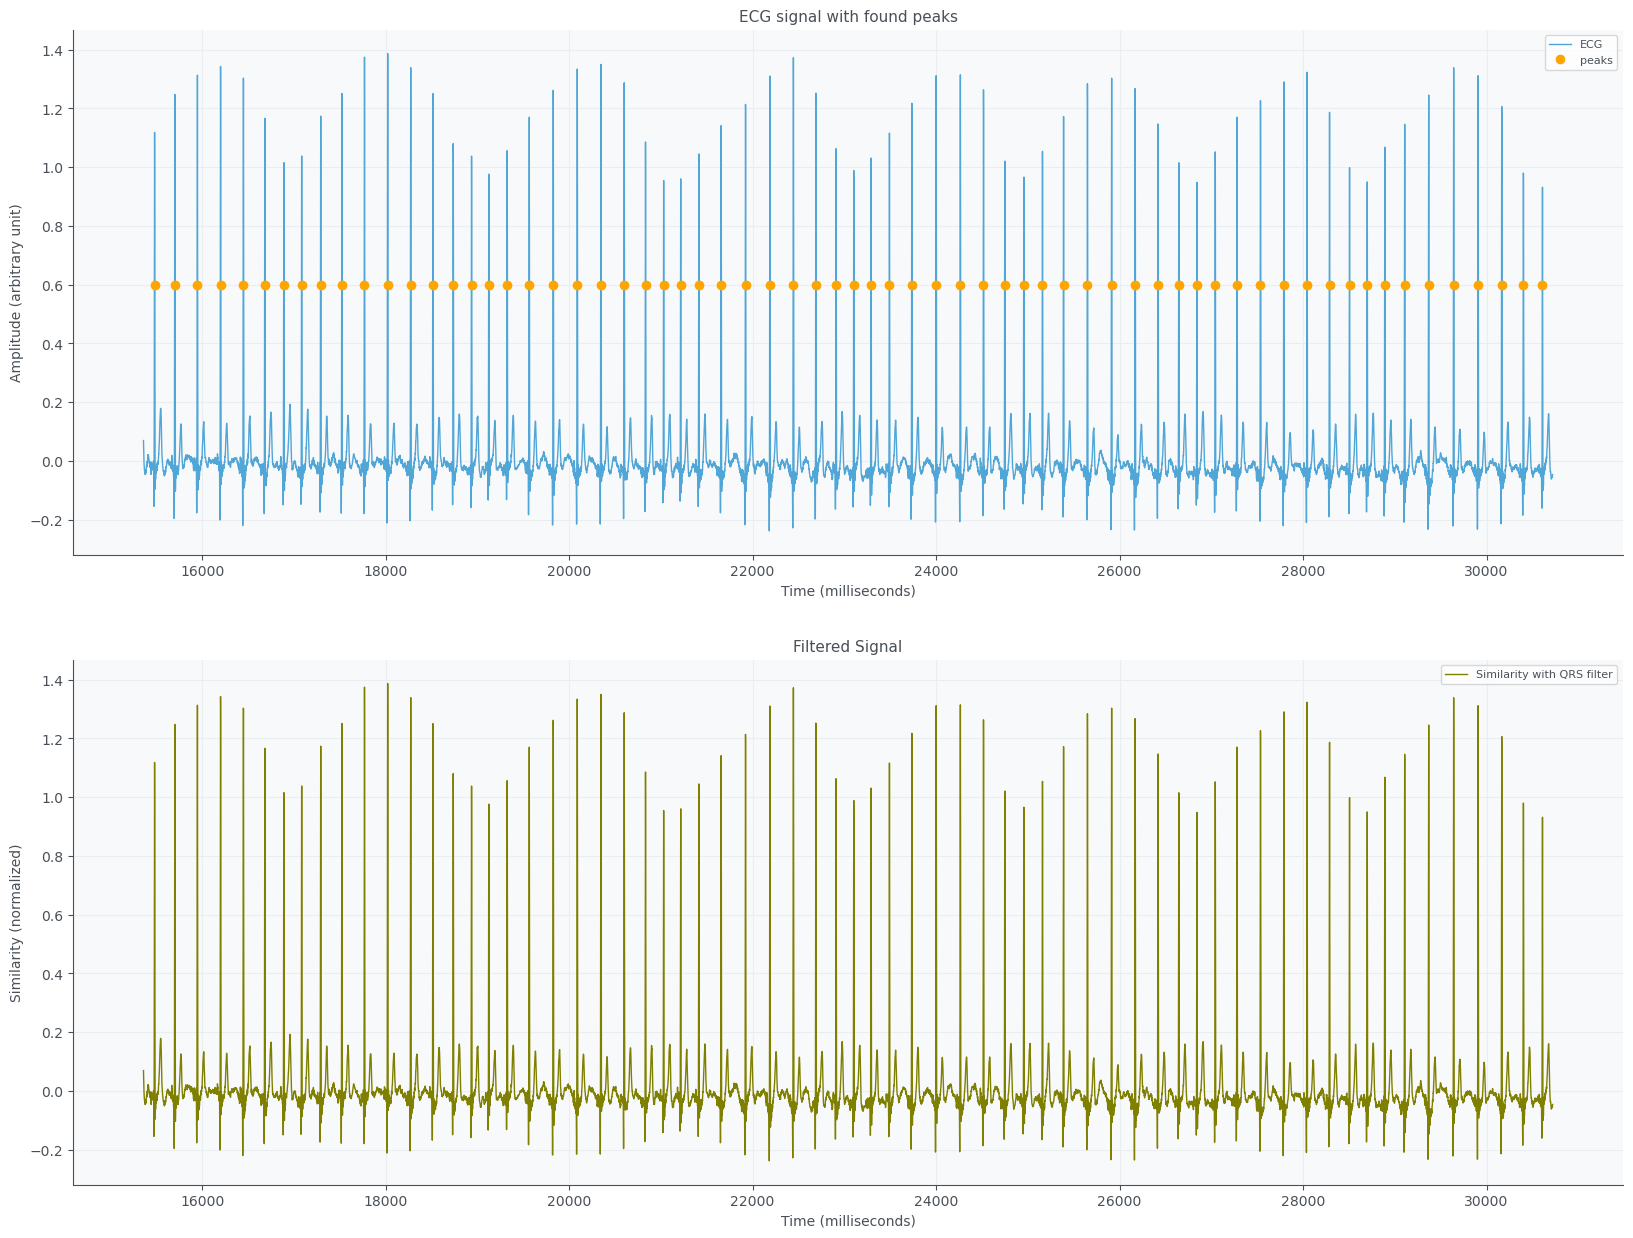

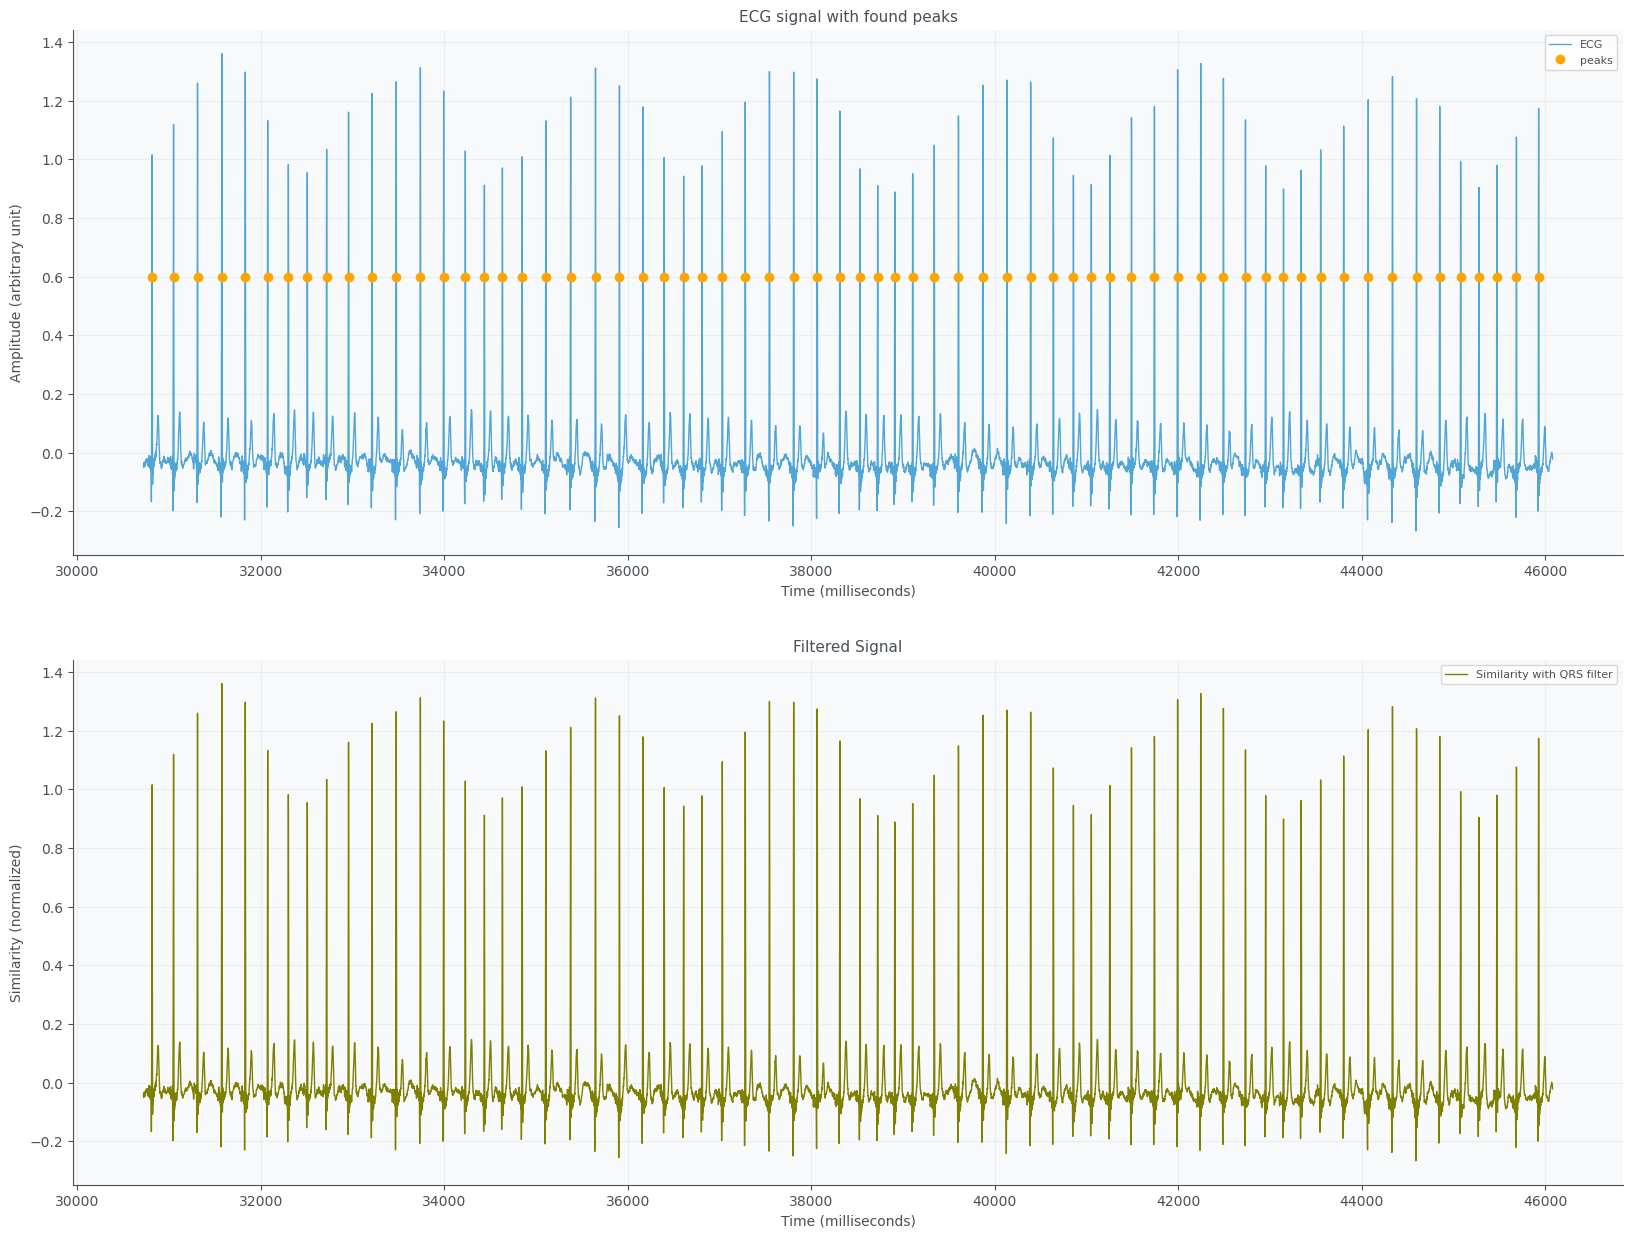

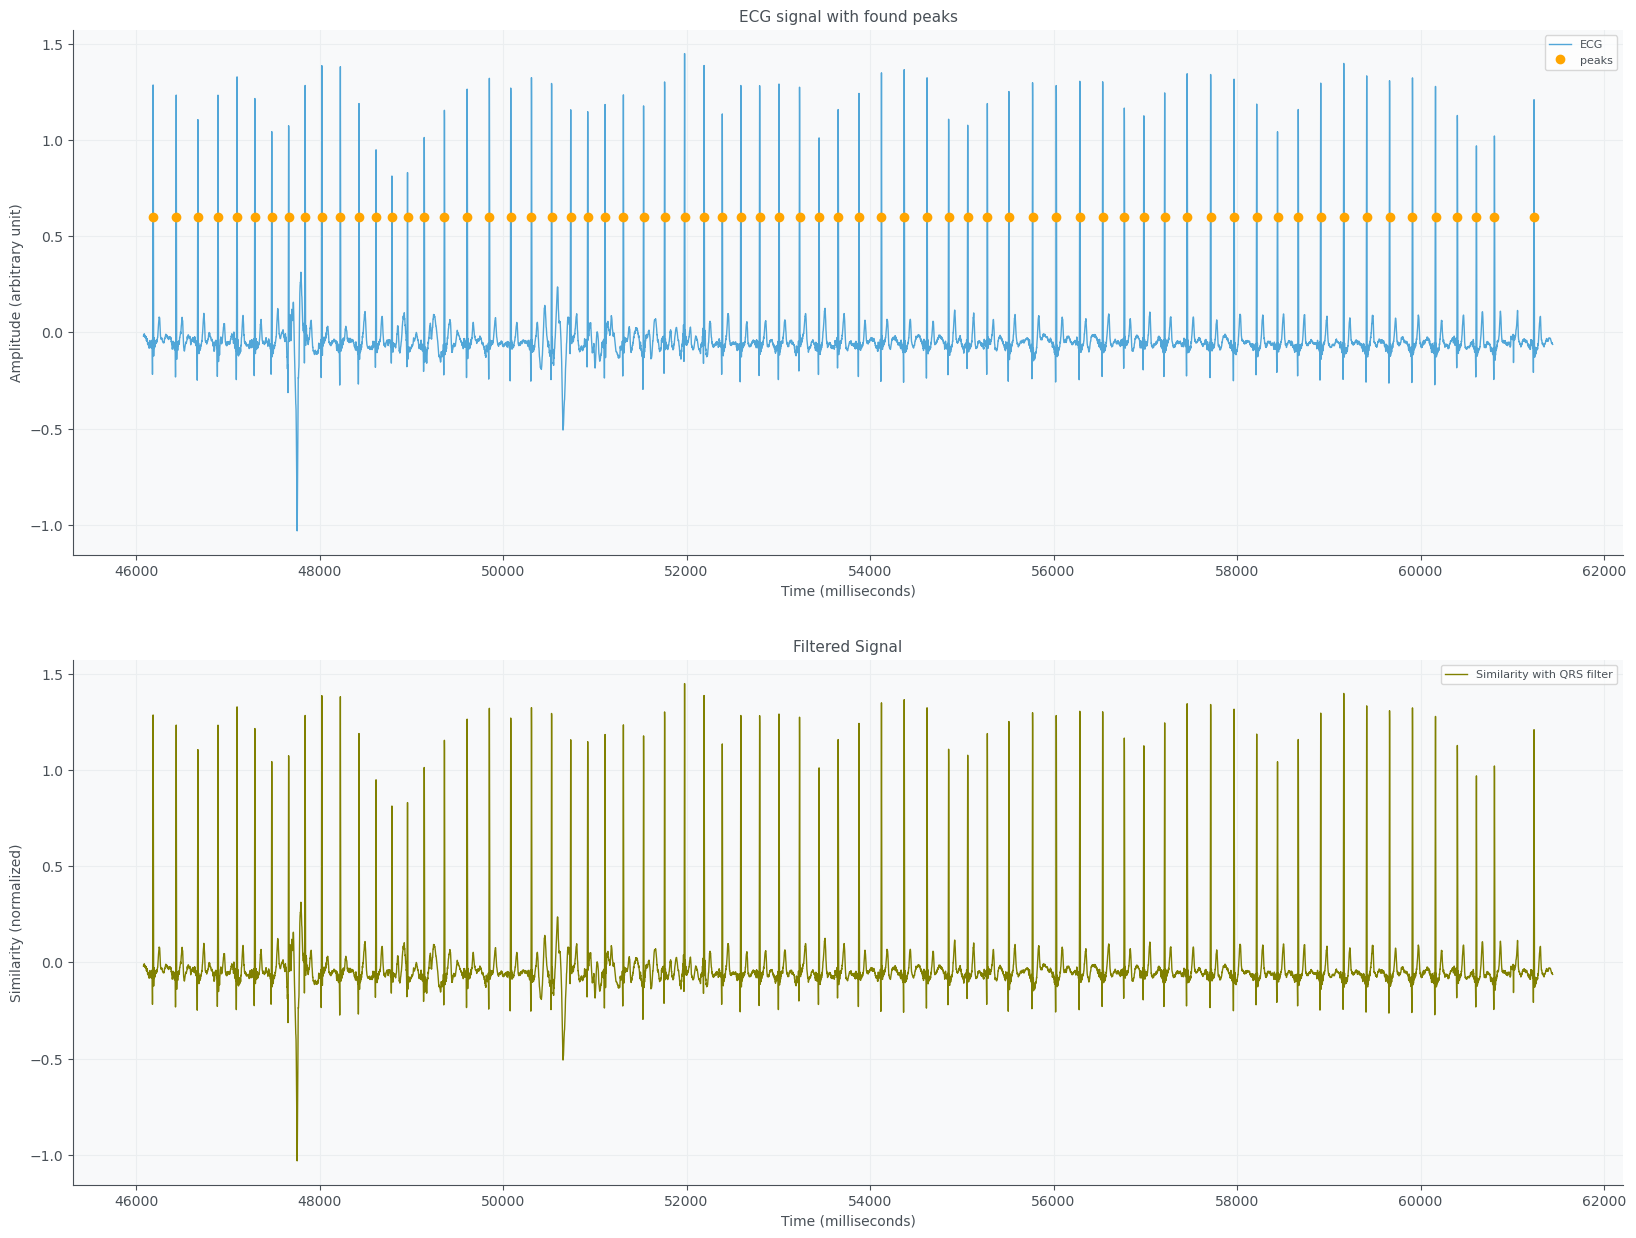

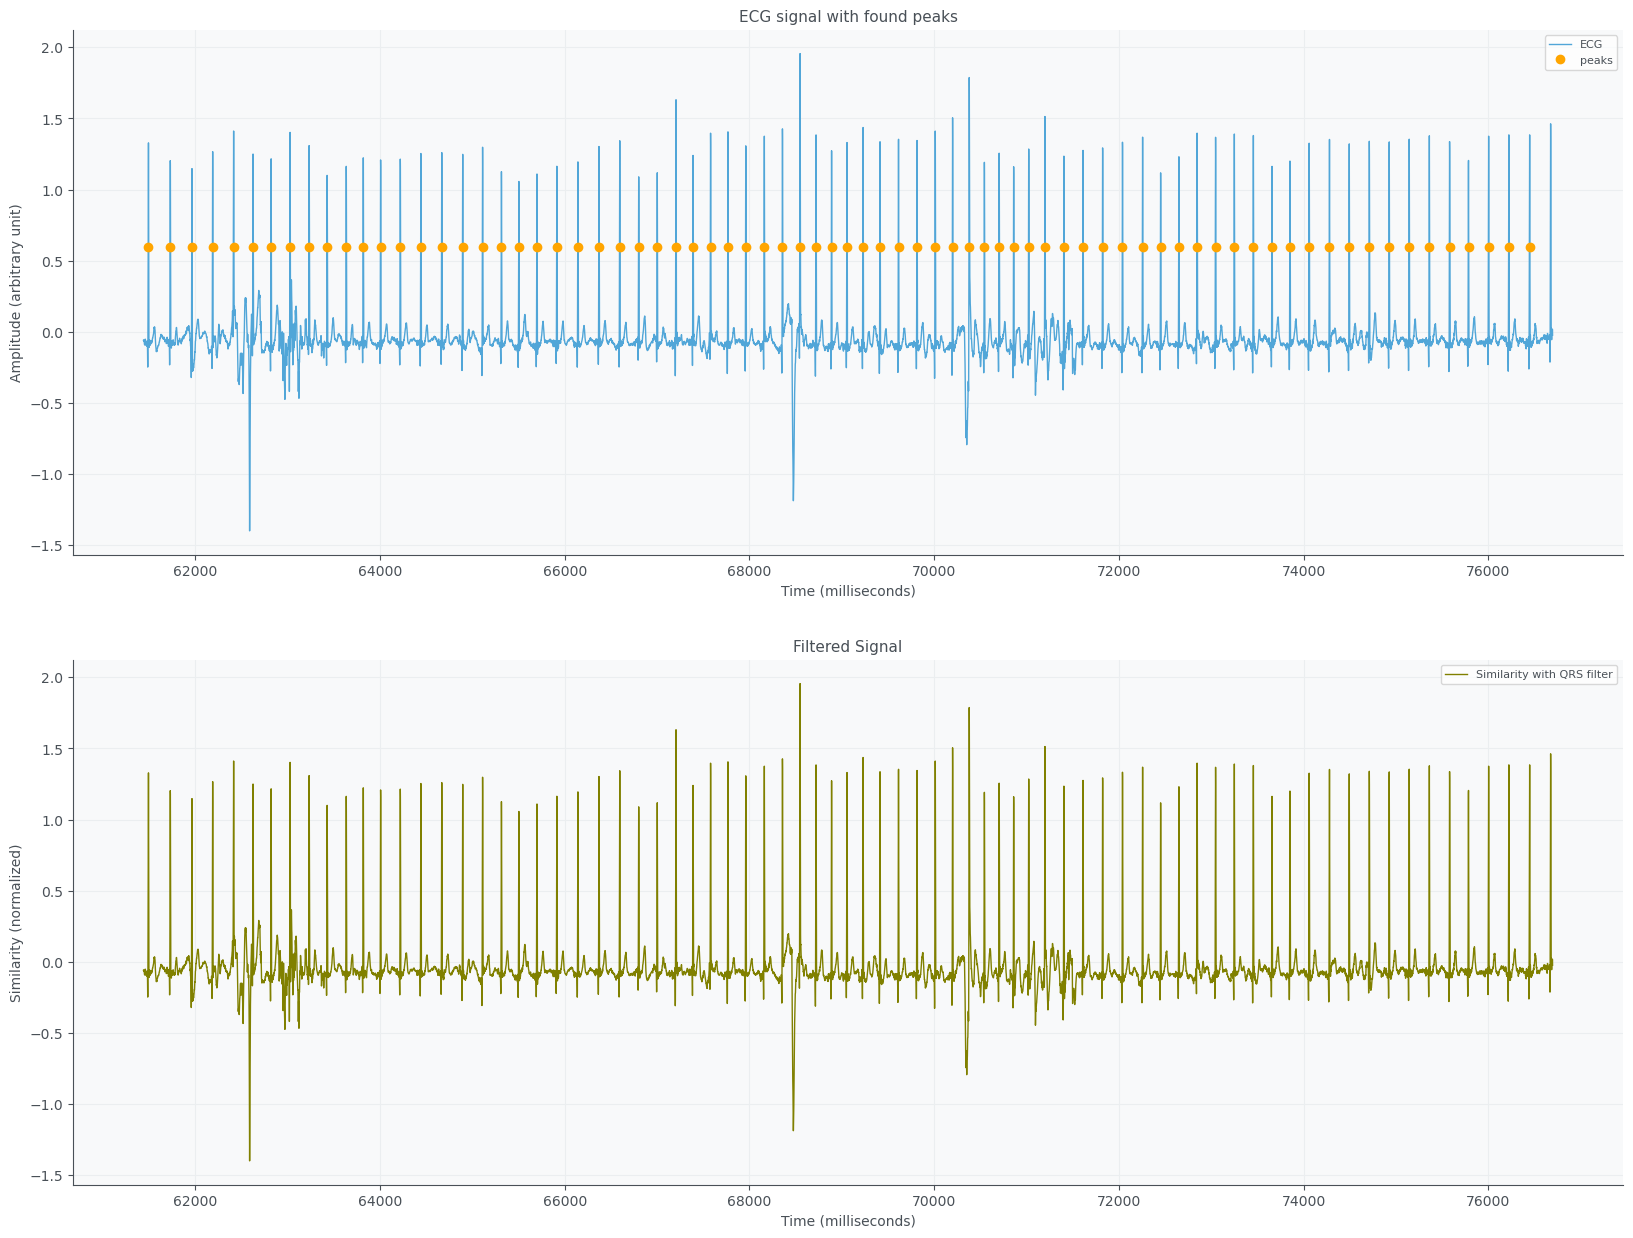

In [47]:
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
    r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]

    # detect peaks
    
    #peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(r_peaks_selected, np.repeat(0.6, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Filtered Signal')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(sliced_ecg_hrv, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    

0
15360
15360
30720
30720
46080
46080
61440
61440
76800


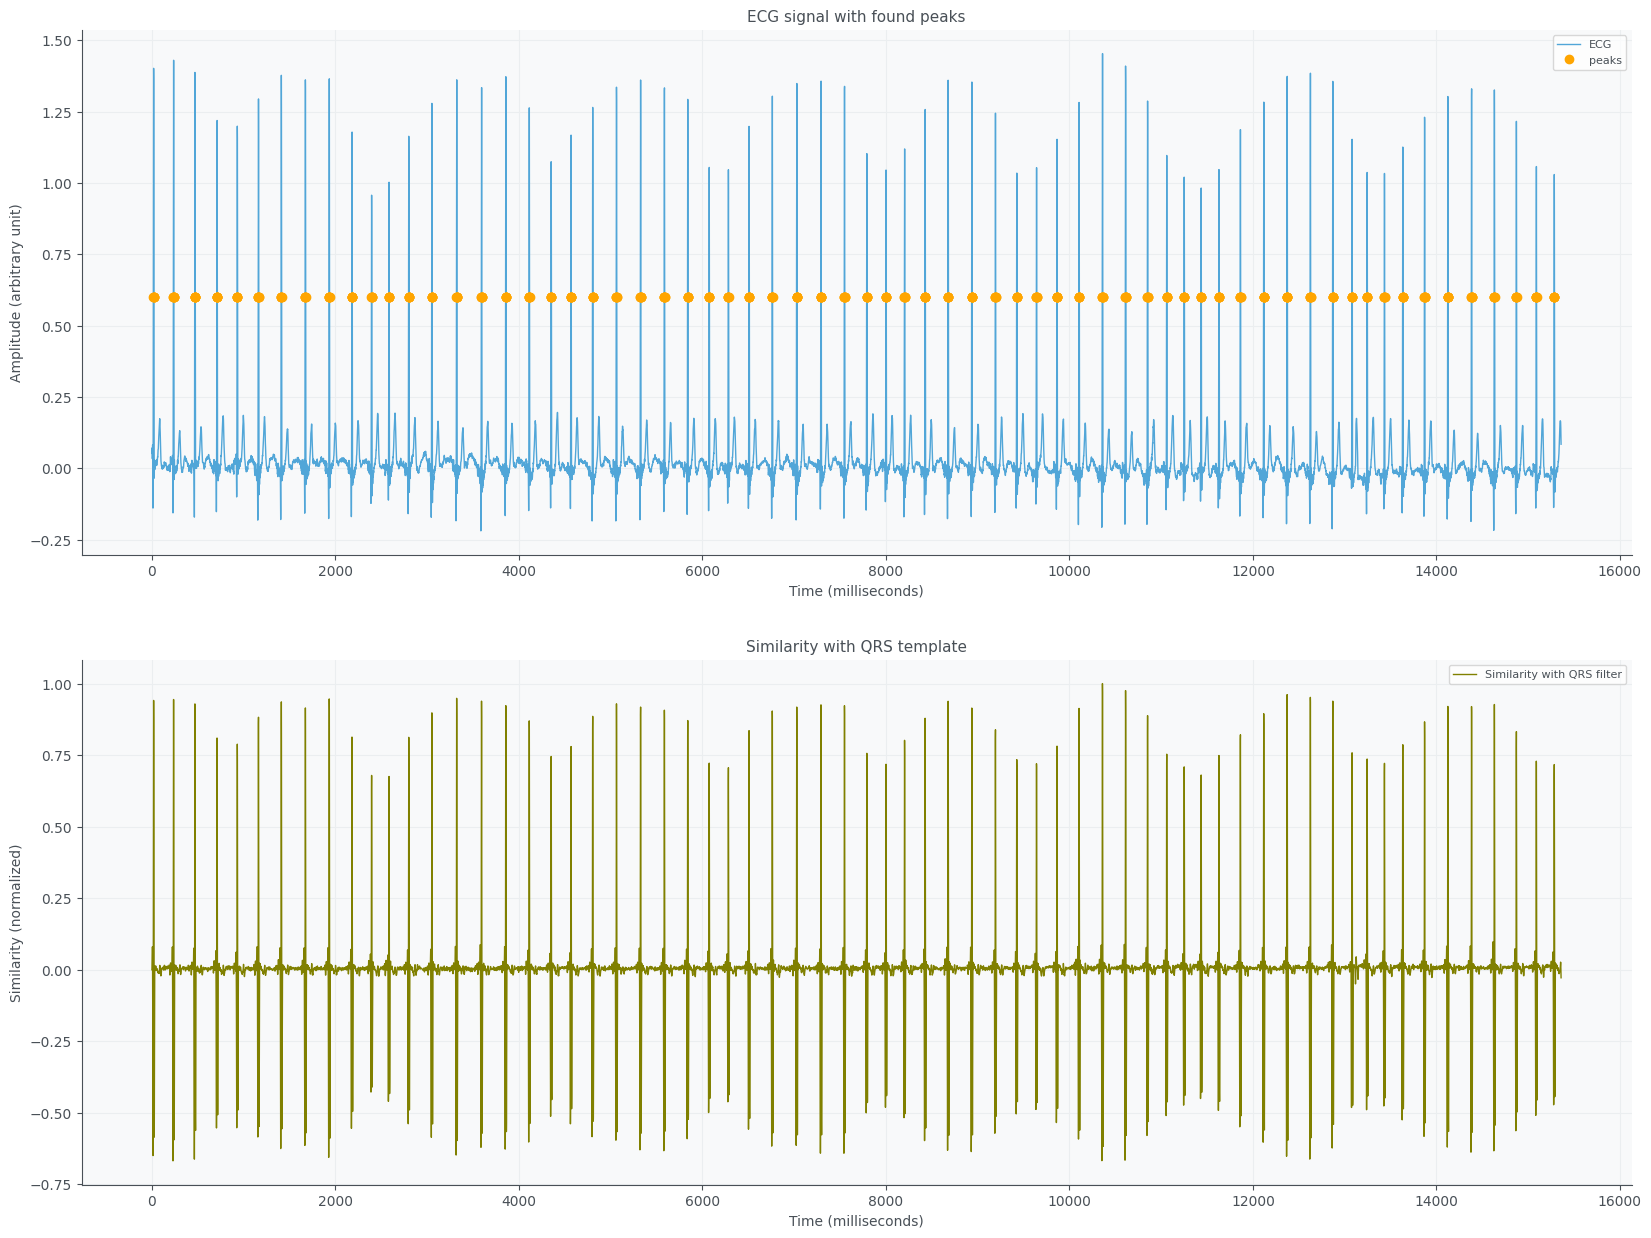

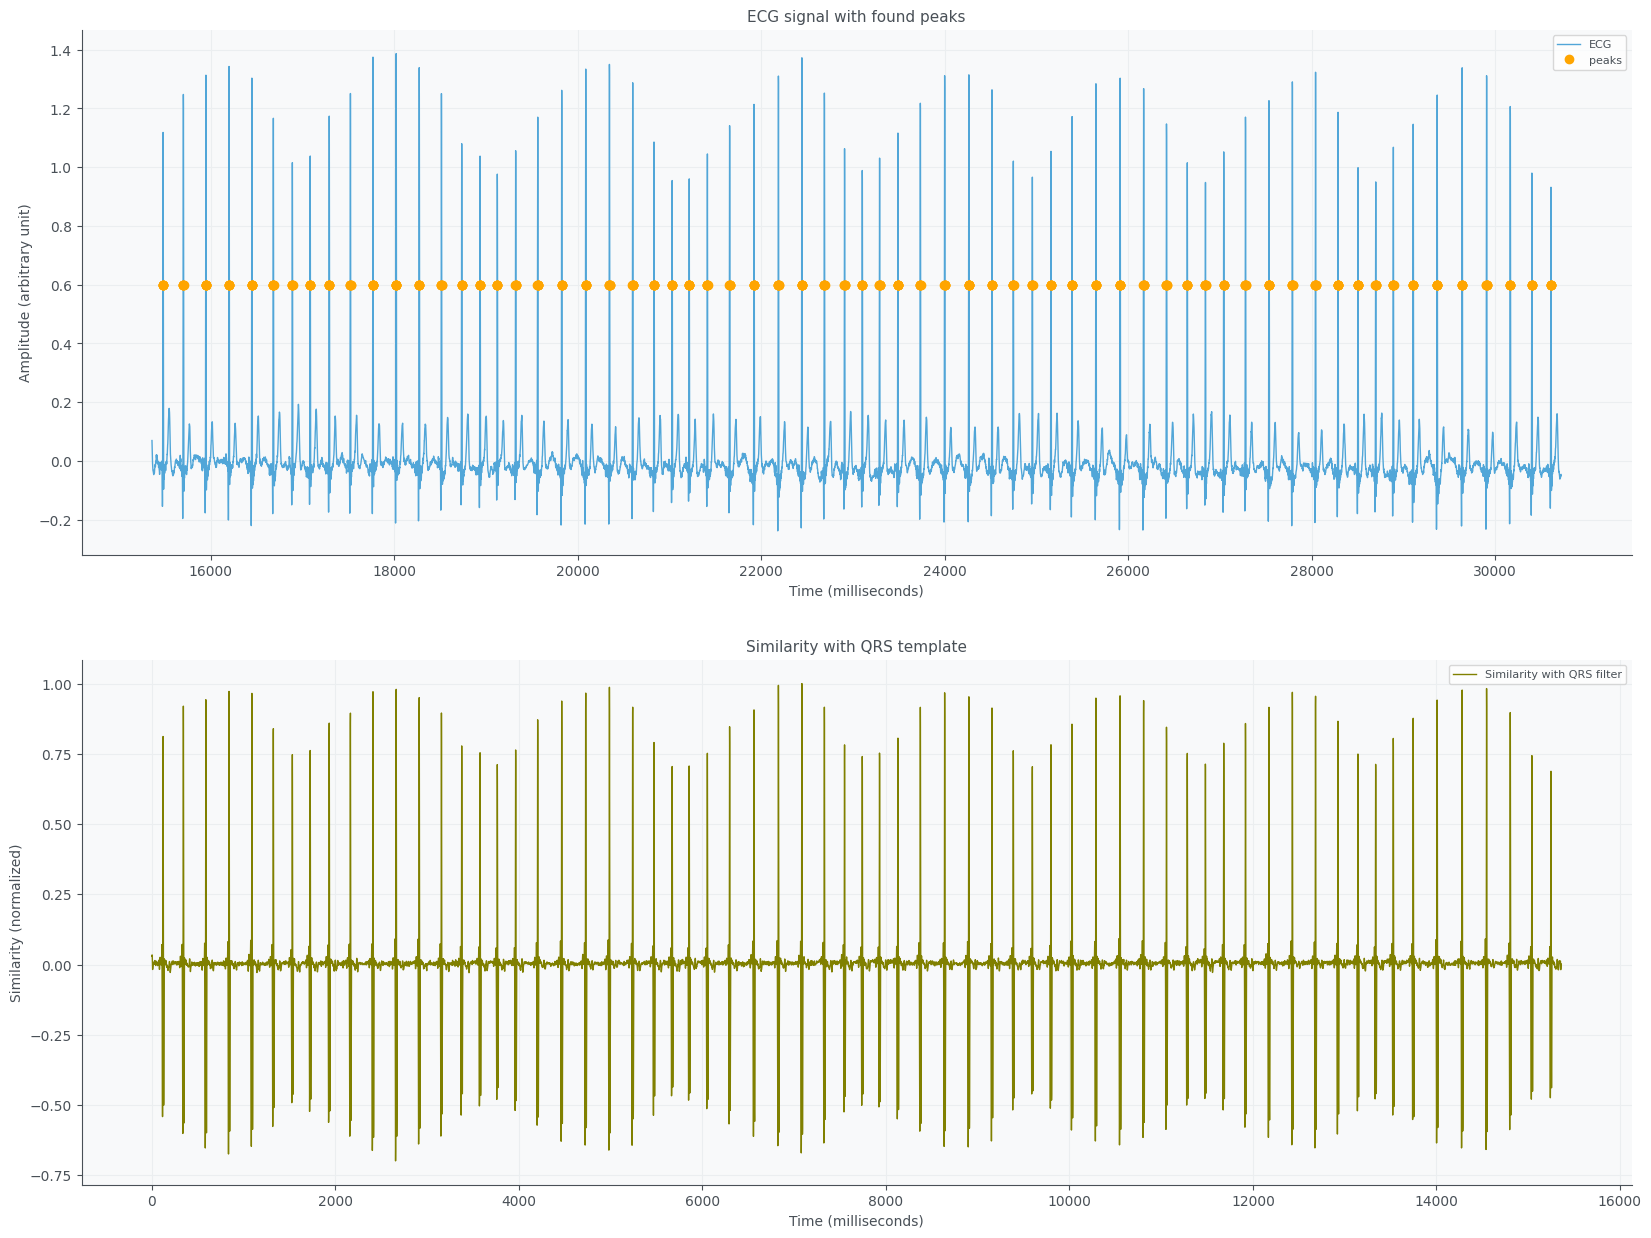

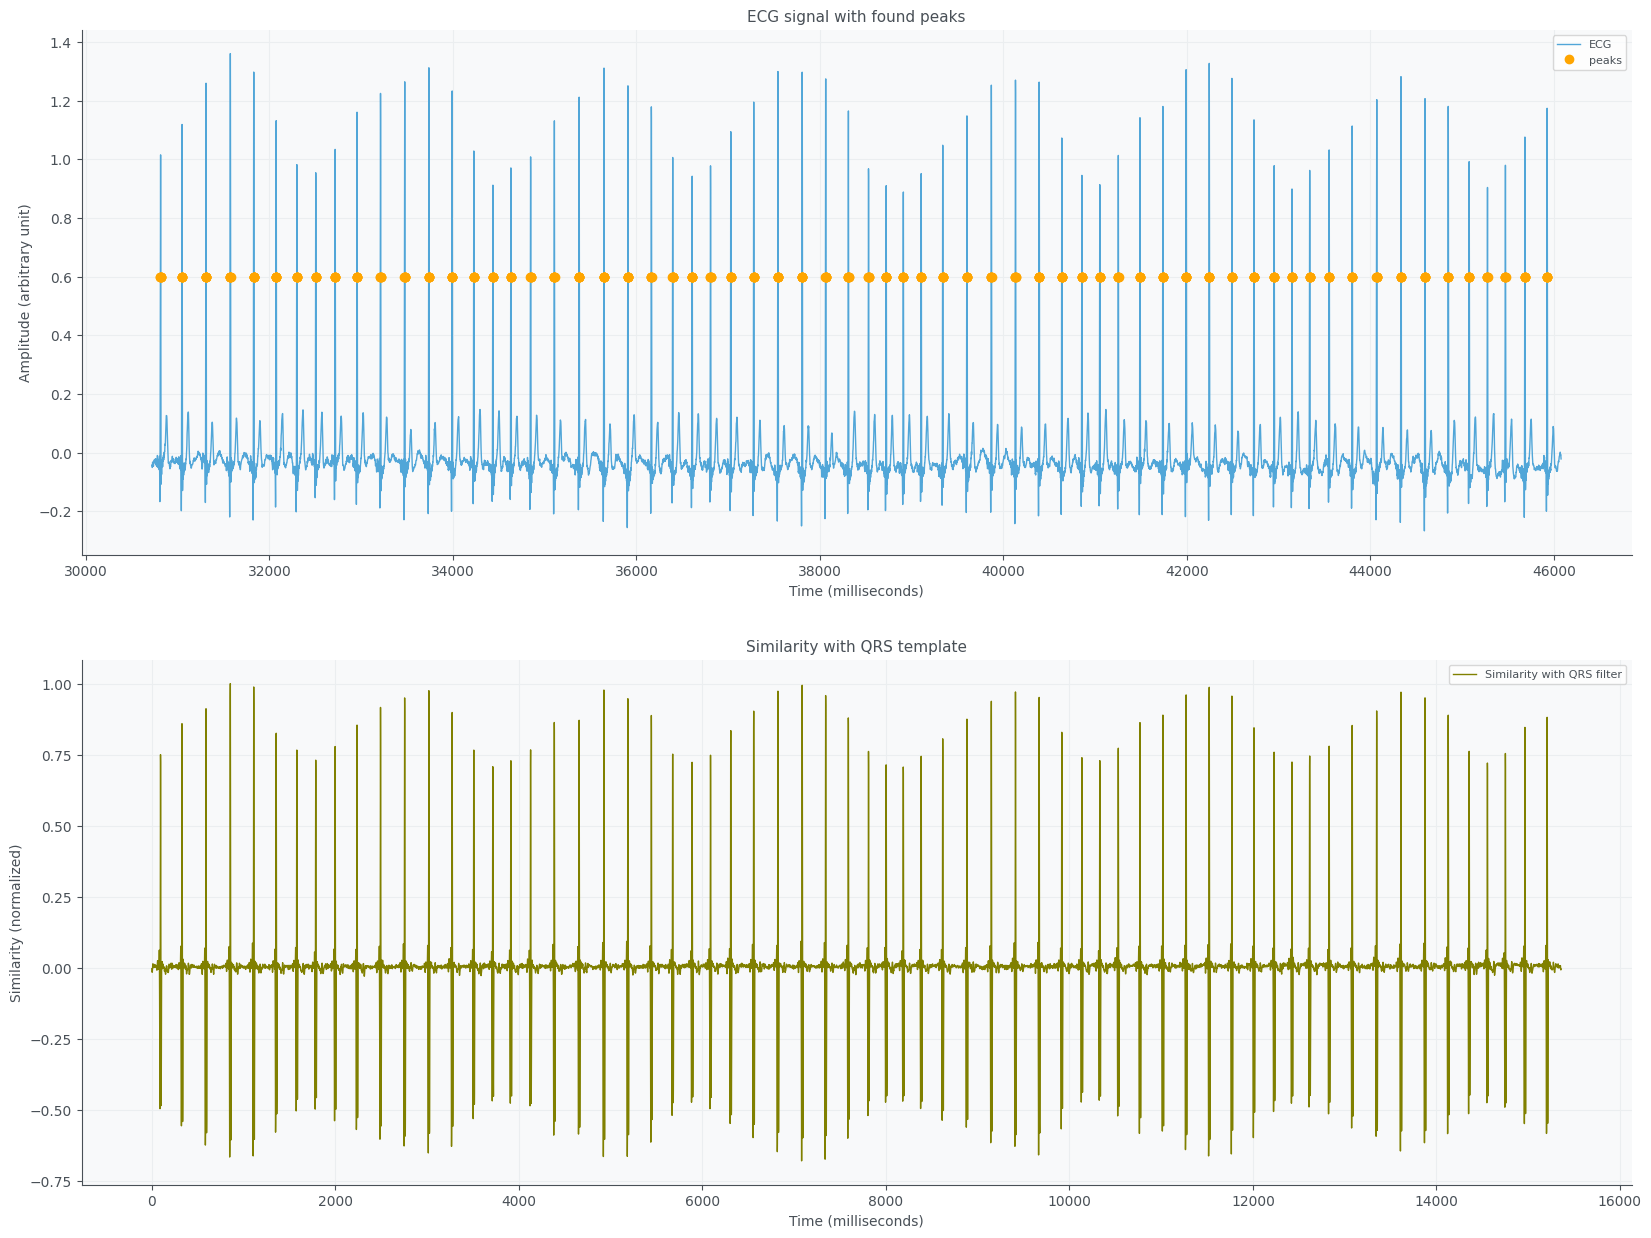

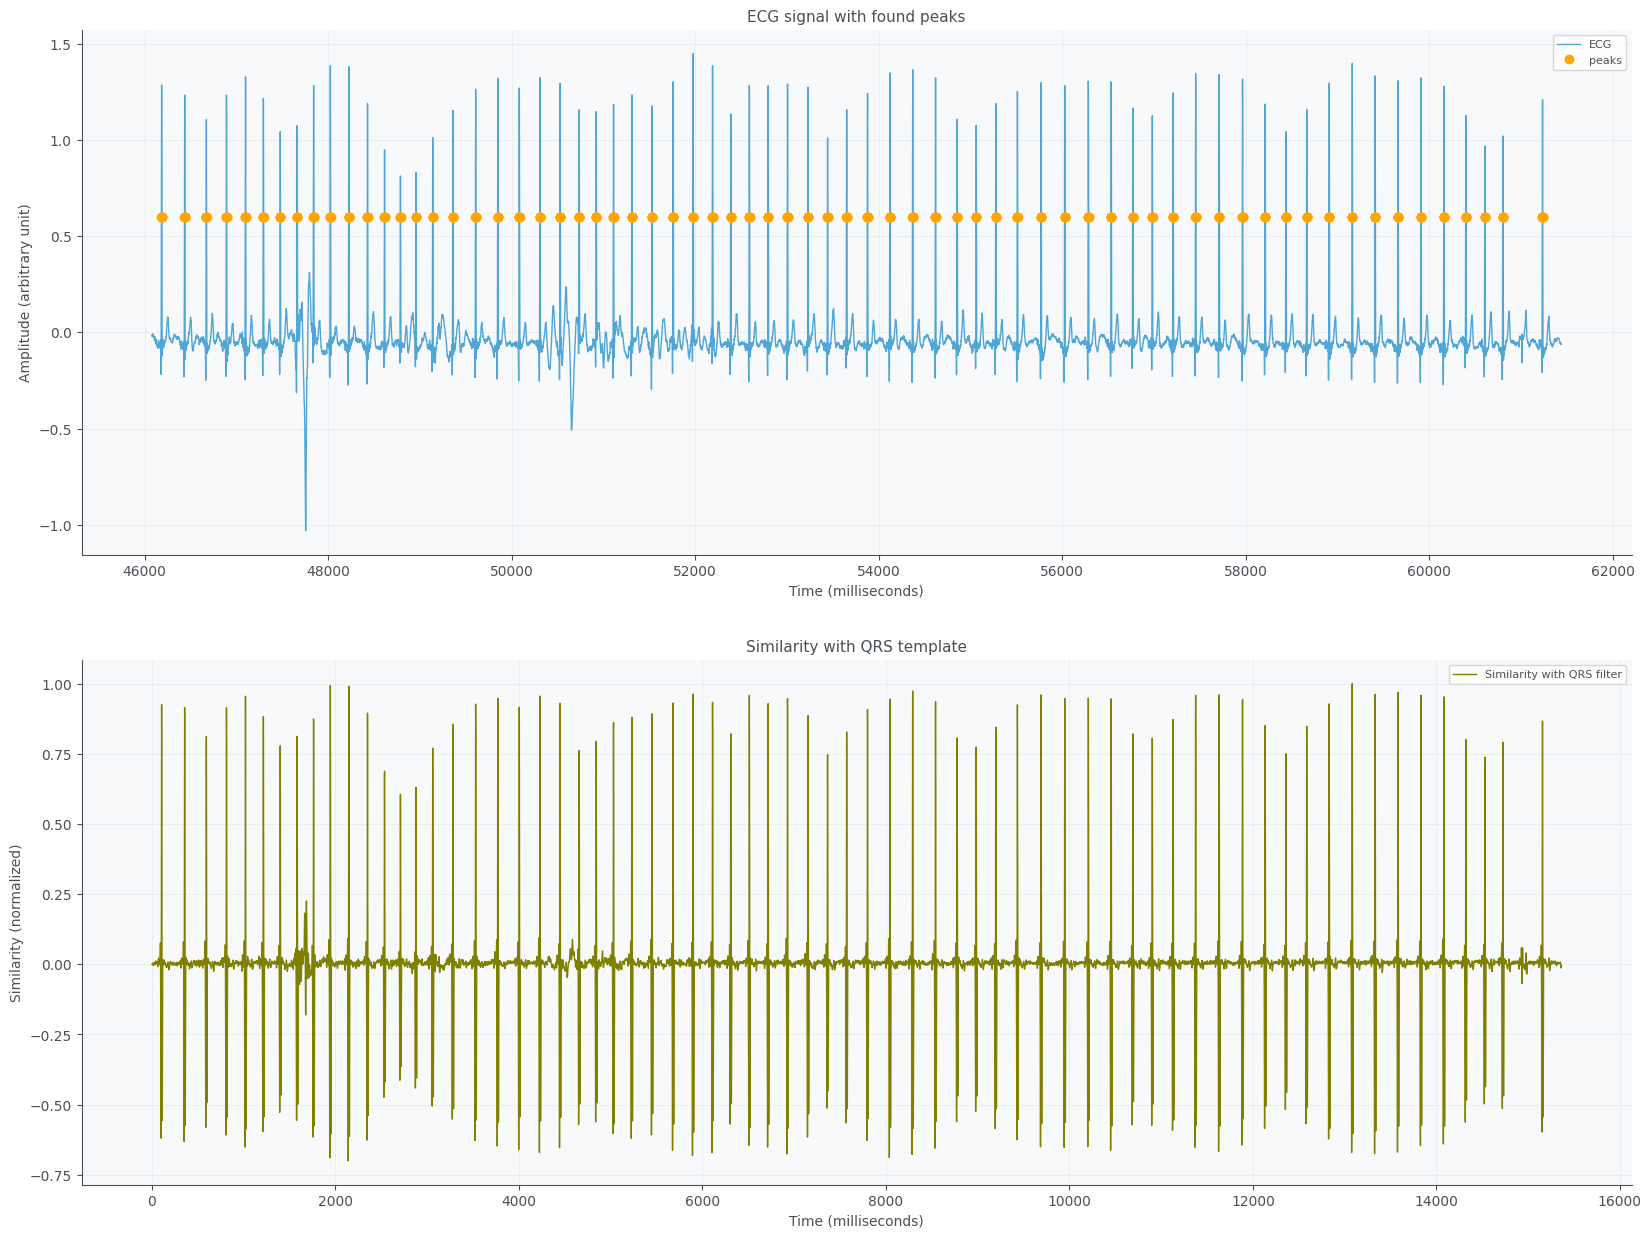

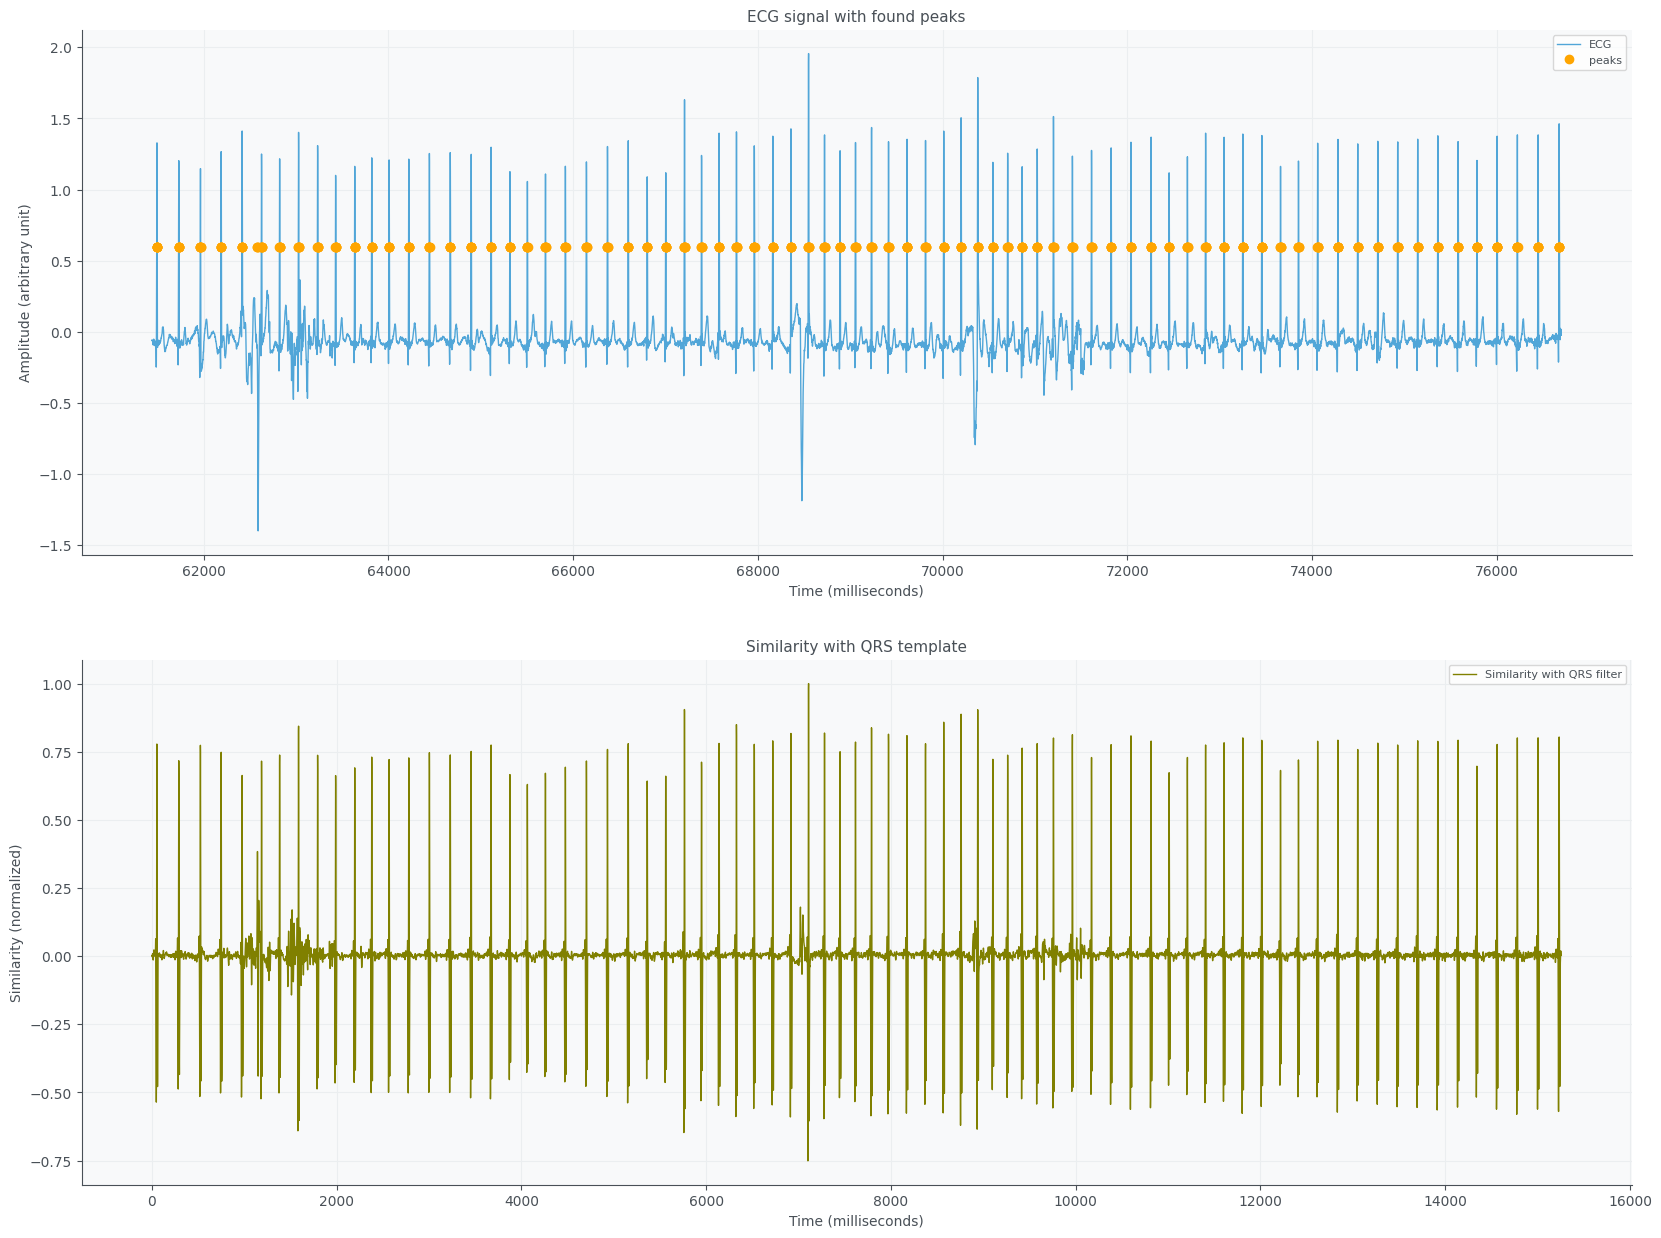

In [307]:
#starting_index_slcide_df= sliced_ecg_df.index[0]
#sampfrom = starting_index_slcide_df
#sampto = starting_index_slcide_df + 256*time_offset*60
#nr_plots = 5

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]

    # detect peaks
    
    peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(0.6, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")
    